<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classficiation-CNN/CNN_to_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries & Set Paths

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set parameters and paths
SPLIT_DATASET_PATH = '/content/drive/MyDrive/DSGP/Splitted_Dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/DSGP/cnn_model.keras'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 10

Create Data Generators

In [3]:
def load_datasets(split_dataset_path, batch_size, img_size):
    TRAIN_DIR = os.path.join(split_dataset_path, 'train')
    VAL_DIR   = os.path.join(split_dataset_path, 'val')
    TEST_DIR  = os.path.join(split_dataset_path, 'test')

    # Load raw training dataset to capture class names
    raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb'
    )
    class_names = raw_train_dataset.class_names
    print("Classes:", class_names)

    # Load raw validation and test datasets
    raw_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb'
    )
    raw_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb',
        shuffle=False  # Keep order for evaluation
    )

    # Optimize the dataset pipeline with caching and prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = raw_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    val_dataset   = raw_val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset  = raw_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    return train_dataset, val_dataset, test_dataset, class_names

Build & Compile the CNN Model

In [4]:
def build_model(img_size, num_classes):
    model = models.Sequential([

        layers.Input(shape=(224,224,3)),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

Train & Save the Model

In [5]:
def train_model(model, train_dataset, val_dataset, epochs):
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset
    )
    return history

def save_model_keras(model, model_save_path):
    model.save(model_save_path)
    print("Model saved successfully at:", model_save_path)

Plot Training History

In [6]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

Evaluate the Model

In [7]:
def evaluate_model(model, test_dataset, class_names):
    predictions = model.predict(test_dataset, verbose=1)
    predicted_labels = np.argmax(predictions, axis=1)

    # Extract true labels from the test dataset
    true_labels = []
    for images, labels in test_dataset:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
    true_labels = np.array(true_labels)

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Main Execution

Found 25600 files belonging to 16 classes.
Classes: ['astrocitoma', 'carcinoma', 'ependimoma', 'ganglioglioma', 'germinoma', 'glioblastoma', 'granuloma', 'meduloblastoma', 'meningioma', 'neurocitoma', 'no_tumour', 'oligodendroglioma', 'papiloma', 'pituitary', 'schwannoma', 'tuberculoma']
Found 3200 files belonging to 16 classes.
Found 3200 files belonging to 16 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 25,984,304 (99.12 MB)

 Trainable params: 25,982,896 (99.12 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 687s 837ms/step - accuracy: 0.7833 - loss: 0.7849 - val_accuracy: 0.9859 - val_loss: 0.0411
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9925 - loss: 0.0307 - val_accuracy: 0.9937 - val_loss: 0.0212
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9964 - loss: 0.0150 - val_accuracy: 0.9688 - val_loss: 0.0889
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9955 - loss: 0.0189 - val_accuracy: 0.9741 - val_loss: 0.0984
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9948 - loss: 0.0188 - val_accuracy: 0.9825 - val_loss: 0.0615
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9972 - loss: 0.0113 - val_accuracy: 0.9941 - val_loss: 0.0208
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9968 - loss: 0.0112 - val_accuracy: 0.9947 - val_loss: 0.0188
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9973 - loss: 0.0100 

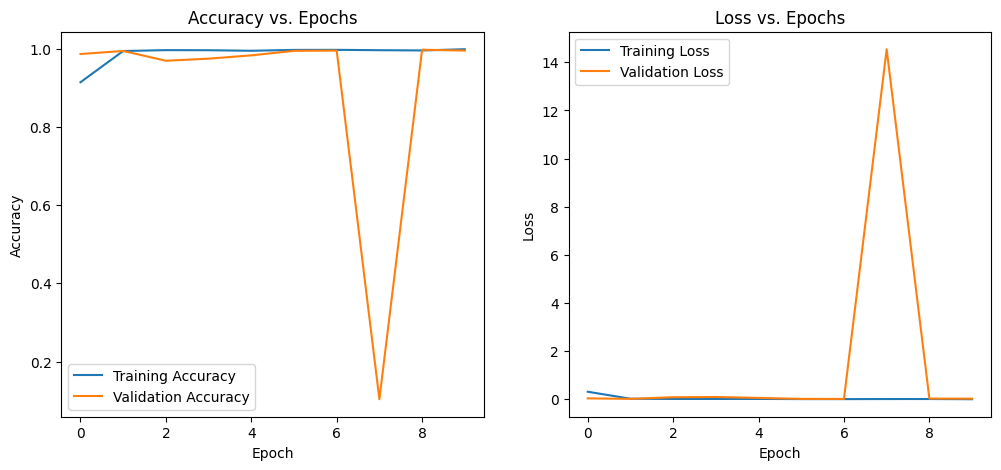

100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 731ms/step
Classification Report:
                   precision    recall  f1-score   support

      astrocitoma       1.00      1.00      1.00       200
        carcinoma       1.00      1.00      1.00       200
       ependimoma       1.00      0.99      0.99       200
    ganglioglioma       1.00      1.00      1.00       200
        germinoma       1.00      1.00      1.00       200
     glioblastoma       1.00      1.00      1.00       200
        granuloma       1.00      1.00      1.00       200
   meduloblastoma       1.00      1.00      1.00       200
       meningioma       0.95      0.95      0.95       200
      neurocitoma       0.99      1.00      1.00       200
        no_tumour       0.99      0.99      0.99       200
oligodendroglioma       1.00      1.00      1.00       200
         papiloma       1.00      1.00      1.00       200
        pituitary       0.97      0.94      0.96       200
       schwannoma       0.99      1.00      1.0

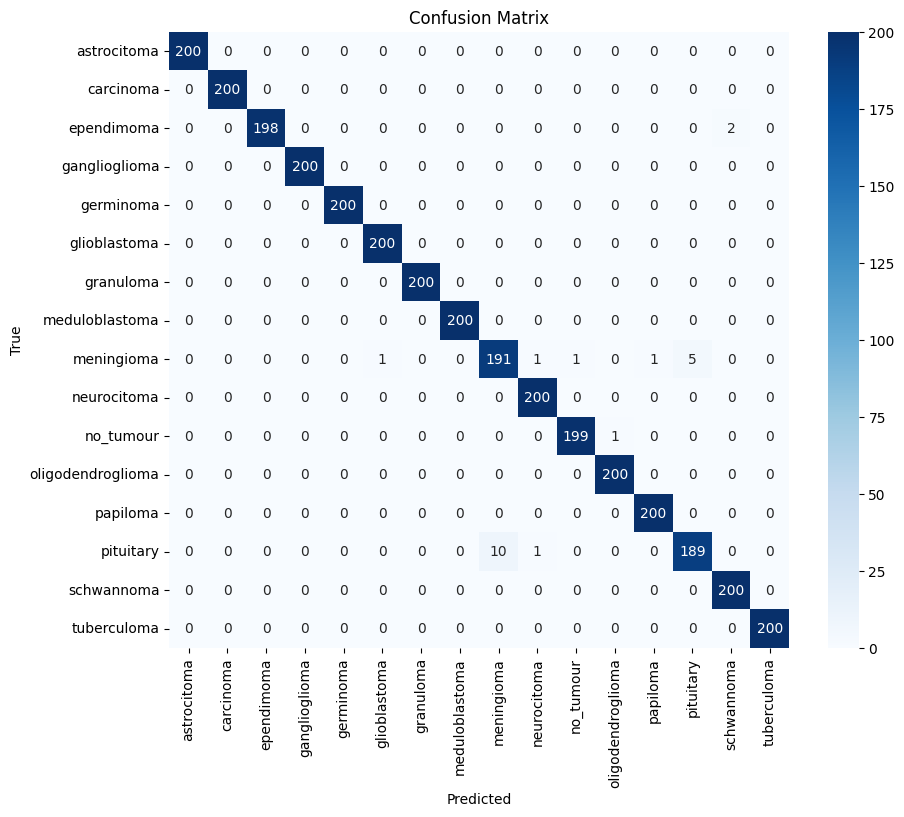

In [8]:
if __name__ == '__main__':
    # Load datasets and get class names
    train_dataset, val_dataset, test_dataset, class_names = load_datasets(SPLIT_DATASET_PATH, BATCH_SIZE, IMG_SIZE)
    num_classes = len(class_names)

    # Build and compile the model
    model = build_model(IMG_SIZE, num_classes)

    # Train the model
    history = train_model(model, train_dataset, val_dataset, EPOCHS)

    # Save the model in Keras format
    save_model_keras(model, MODEL_SAVE_PATH)

    # Plot training history
    plot_training_history(history)

    # Evaluate the model on the test dataset
    evaluate_model(model, test_dataset, class_names)

Test with some Example Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


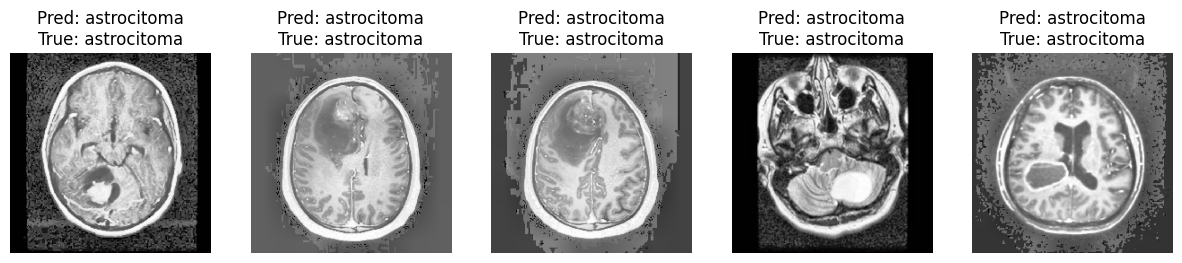

In [9]:
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels.numpy(), axis=1)

    num_images_to_show = 5
    plt.figure(figsize=(15, 3))
    for i in range(num_images_to_show):
        ax = plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        pred_class = class_names[predicted_labels[i]]
        true_class = class_names[true_labels[i]]

        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


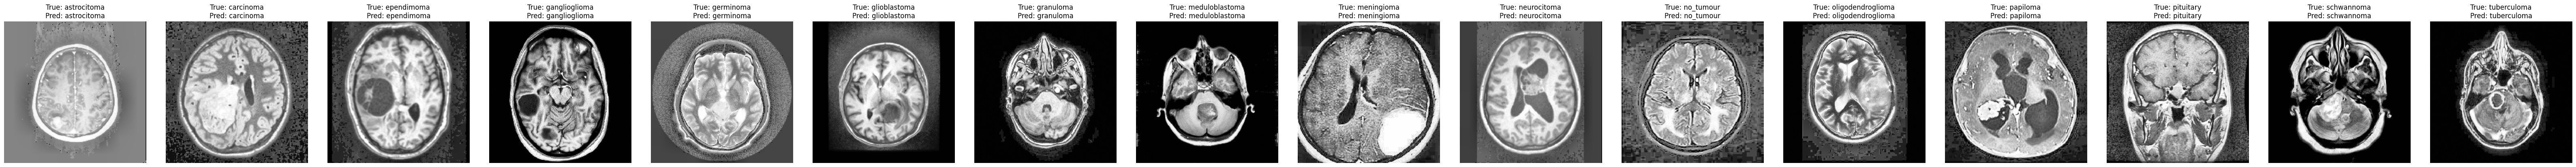

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Base directory for test images
BASE_TEST_DIR = '/content/drive/MyDrive/DSGP/Splitted_Dataset/test'

# Number of classes (assumes class_names is already defined)
num_classes = len(class_names)

# Create a figure for displaying one image per class
plt.figure(figsize=(4 * num_classes, 4))

# Loop over each class
for i, cls in enumerate(class_names):
    class_dir = os.path.join(BASE_TEST_DIR, cls)
    # Get list of image files in the current class folder
    file_list = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(file_list) == 0:
        continue  # Skip if no images found
    # Choose the first image (or use random.choice(file_list) for a random selection)
    img_file = file_list[0]
    img_path = os.path.join(class_dir, img_file)

    # Load the image with target size of 224x224
    img = load_img(img_path, target_size=(224, 224), color_mode='rgb')
    # Convert the image to a numpy array; do NOT normalize here if model handles it
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Get predictions from the model
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_names[predicted_class_index]

    # Plot the image with predicted label
    ax = plt.subplot(1, num_classes, i + 1)
    plt.imshow(img)
    plt.title(f"True: {cls}\nPred: {predicted_class}")
    plt.axis("off")

plt.tight_layout()
plt.show()